In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 

import pickle
from sklearn import metrics
import nltk
import os
from nltk.corpus import stopwords
from textblob import Word
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv("input621.csv")
df

,Subject,Body
0,SUTDReviews --- Sharing reviews on SUTD Mods,SUTDFam!!\r\n\r\n \r\n\r\nHaving trouble deci...
1,Request for Interview for Pedagogical Project,",\r\n\r\nThanks for responding. The online fo..."
2,Change of Name for the ISTD Degree Programme,"Students,\r\n\r\n \r\n\r\nSUTD will be changi..."
3,Fw: 88 Call for Stories,\r\n\r\n________________________________\r\n\r...
4,Revised Student Exco and Cohort Advisor prog...,"Student Reps,\r\n\r\n \r\n\r\nThank you for y..."
...,...,...
589,2021 September Term - 10.022 : Modelling Uncer...,"students,\r\n\r\n(1) Please be reminded that ..."
590,2021 T3 End Term Surveys,", \r\n\r\nThe End Term Surveys are now open ..."
591,Request for Quotation,External Email – Do not click on any links or ...
592,Enquiry on Term 3 Fund,",\r\n\r\n \r\n\r\nDue to the current COVID si..."


In [3]:
df['Body'] = df['Body'].astype(str)
df['Body'] = df['Body'].apply(lambda x: x.lower())
punctuations = '\.\!\?'
df = (df.drop('Body',axis=1).merge(df.Body.str.extractall(f'(?P<Body>[^{punctuations}]+[{punctuations}])\s?').reset_index('match'),left_index=True, right_index=True, how='left'))
df['Body'] = df['Body'].str.replace("[^\w\s<>]", "")
df = df.replace(r'[^0-9a-zA-Z ]', '', regex=True).replace("'", '')
#print(type(df['Body']))
#df.applymap(type)
df['Body'] = df['Body'].astype(str)
df['Body'] = df['Body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) # change similar terms to the same
stop = stopwords.words("english") #remove useless words
df['Body'] = df['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

df

C:\Users\PC\AppData\Local\Temp\ipykernel_17684\665876134.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Body'] = df['Body'].str.replace("[^\w\s<>]", "")


,Subject,match,Body
0,SUTDReviews Sharing reviews on SUTD Mods,0.0,sutdfam
0,SUTDReviews Sharing reviews on SUTD Mods,1.0,trouble deciding mod take
0,SUTDReviews Sharing reviews on SUTD Mods,2.0,want find taken
0,SUTDReviews Sharing reviews on SUTD Mods,3.0,fret
0,SUTDReviews Sharing reviews on SUTD Mods,4.0,sutd senior came together create sutdreviews a...
...,...,...,...
593,EPF Freshnomore Event,381.0,confirming collection date srts would send nam...
593,EPF Freshnomore Event,382.0,hope get approval
593,EPF Freshnomore Event,383.0,feel free contact 97705194 clarification
593,EPF Freshnomore Event,384.0,sincerely root


In [4]:
#vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)

# max_df removes words that appears more than _%
# min_df removes words that appears less than _

vect = TfidfVectorizer(ngram_range=(1,3),
                     min_df = 20,
                     max_df = 0.4,
                     token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]+\\w*\\b')
X = vect.fit_transform(df['Body'].values.astype('U'))

d:\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
d:\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


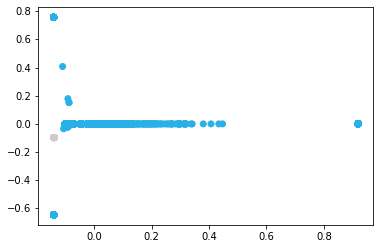

In [5]:
# Kmeans
from sklearn.cluster import KMeans
n_clusters = 4
clf = KMeans(n_clusters=n_clusters, max_iter=300, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

# For larger datasets use mini-batch KMeans, so we dont have to read all data into memory.
# batch_size = 500
# clf = MiniBatchKMeans(n_clusters=n_clusters, init_size=1000, batch_size=batch_size, max_iter=100)  
# labels = clf.fit(X)

# Let's plot this with matplotlib to visualize it.
# First we need to make 2D coordinates from the sparse matrix.
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

# Lets plot it again, but this time we add some color to it.
# This array needs to be at least the length of the n_clusters.
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]
# Plot clusters
plt.scatter(coords[:, 0], coords[:, 1], c=colors)





In [6]:
# top keywords in the emails

def top_tfidf_feats(row, features, top_n=20000):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 10))

                   features     score
0                   trouble  0.830341
1                      take  0.557256
2          zoom meetingsutd  0.000000
3          fully vaccinated  0.000000
4  fully vaccinated covid19  0.000000
5                       fun  0.000000
6                      fund  0.000000
7                fund claim  0.000000
8         fund claim procre  0.000000
9             fund purchase  0.000000


d:\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [7]:
# top terms out of all the emails
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=20000):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

print(top_mean_feats(X, features, top_n=10))

               features     score
0                  sutd  0.083696
1            protection  0.037129
2             safelinks  0.037033
3               outlook  0.036867
4                 apc01  0.022874
5                 thank  0.022018
6               student  0.011645
7          url3a2f2fwww  0.011416
8    mailcrystalquasutd  0.010507
9  maileventsstudentgov  0.009599


In [8]:
# extracts the top terms per cluster
features = vect.get_feature_names()
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=10):
    dfs = []
    print(y)
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

top_feats_per_cluster(X, labels, features, min_tfidf=0.1, top_n=10)

[0 0 0 ... 0 0 0]


d:\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[               features     score
 0                  sutd  0.087401
 1            protection  0.038772
 2             safelinks  0.038672
 3                 apc01  0.023886
 4                 thank  0.022993
 5               student  0.012161
 6          url3a2f2fwww  0.011921
 7    mailcrystalquasutd  0.010972
 8  maileventsstudentgov  0.010024
 9  mailsuhartiabdulsutd  0.009929,
                    features  score
 0       url3a2f2fsutdapacmy    1.0
 1          zoom meetingsutd    0.0
 2            full tc please    0.0
 3          fully vaccinated    0.0
 4  fully vaccinated covid19    0.0
 5                       fun    0.0
 6                      fund    0.0
 7                fund claim    0.0
 8         fund claim procre    0.0
 9             fund purchase    0.0,
                            features     score
 0       tel6566358358 tel6591898014  0.346712
 1                tel6591898014 cdn2  0.346712
 2                 png tel6566358358  0.346712
 3                     tel656

[0 0 0 ... 0 0 0]


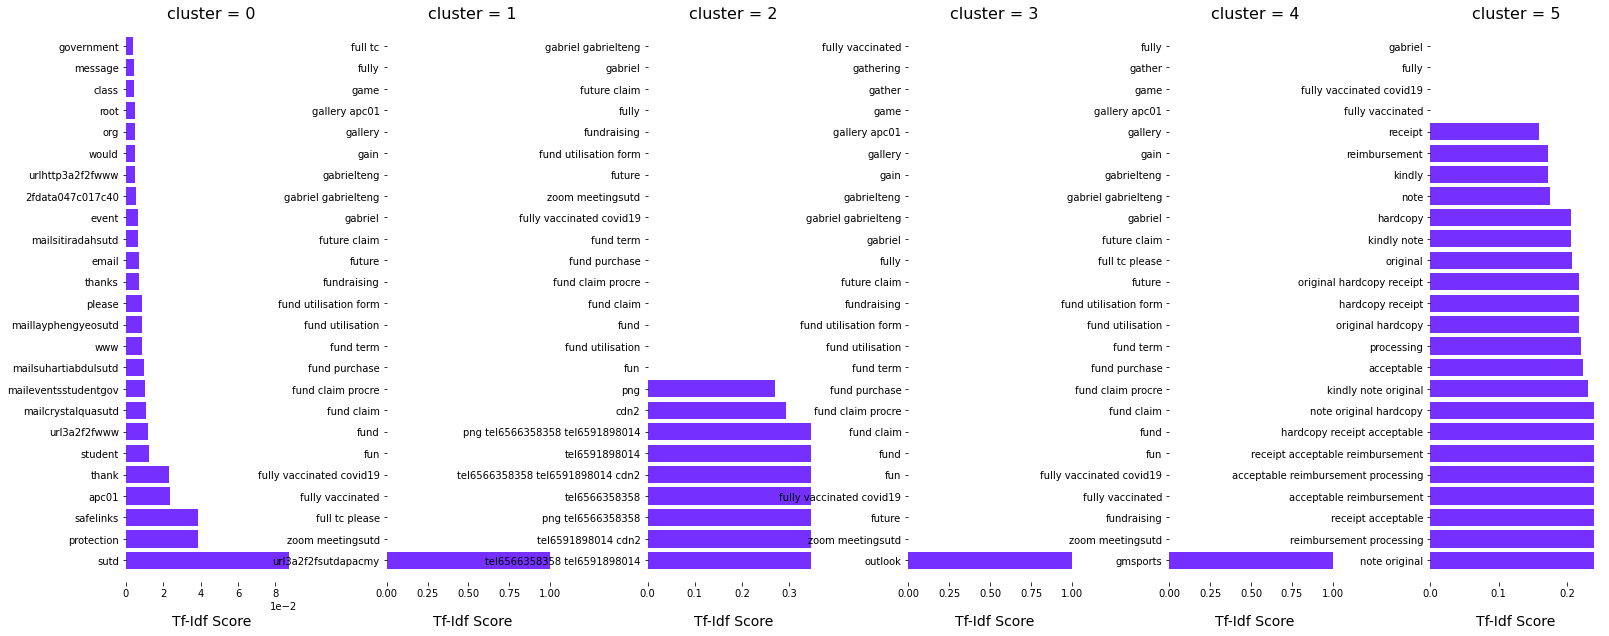

In [9]:
#Use this to print the top terms per cluster with matplotlib.

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(25, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()


plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))

In [10]:
# km = KMeans(n_clusters=5).fit(df)

# cluster_map = pd.DataFrame()
# cluster_map['data_index'] = df.index.values
# cluster_map['cluster'] = clf.labels_

# cluster_map[cluster_map.cluster == 2]
#df.loc[df.ID == 103, 'FirstName'] = "Matt"
#df.loc[df[clf.labels_==0], 'Meetings'] = df.Categories 
#df.loc = df[clf.labels_==0]['Categories'].fillna('Meeting')
#df['Categories'][mask] = "Meeting"
#df.loc[df[clf.labels_==0], 'Categories'] = 'Meeting'

df['Classifications'] = pd.Series(labels, index=df.index)
# df_new = df[df['Classifications'] != 1]
# df_new

X = df['Body']
y = pd.to_numeric(df['Classifications'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

In [11]:
# count every word/phrase and put it into a matrix
vect = TfidfVectorizer(ngram_range=(1,3),
                     min_df = 5,
                     max_df = 0.4,
                     token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]+\\w*\\b')
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [12]:
# converting sparse matrices into dense matrices
# replace empty spaces in the matrices with 0 (some sentences might not have a specific word)
X_train_dense = pd.DataFrame(X_train_dtm.toarray(), columns = vect.get_feature_names())
X_test_dense = pd.DataFrame(X_test_dtm.toarray(), columns = vect.get_feature_names())

d:\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
d:\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
pca = PCA(n_components = 20) # put a reasonable number from graph (70%-90%)
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

In [14]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, criterion="entropy", n_jobs=-1, random_state=0)
rfc.fit(X_train_pca, y_train)
predictions = rfc.predict(X_test_pca)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[7902    0    0    0    0    0]
 [   7    0    0    0    0    0]
 [   0    0    6    0    0    0]
 [   0    0    0  307    0    0]
 [   0    0    0    0   28    0]
 [   7    0    0    0    0    0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7902
           1       0.00      0.00      0.00         7
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00       307
           4       1.00      1.00      1.00        28
           5       0.00      0.00      0.00         7

    accuracy                           1.00      8257
   macro avg       0.67      0.67      0.67      8257
weighted avg       1.00      1.00      1.00      8257



d:\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
cm1 = confusion_matrix(y_test, predictions)
print("Confusion Matrix : \n", cm1)
total1 = sum(sum(cm1))

accuracy1 = (cm1[0,0] + cm1[1,1])/total1
print("Accuracy :", accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print("Sensitivity :", sensitivity1)

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print("Specificity :", specificity1)

Confusion Matrix : 
 [[7902    0    0    0    0    0]
 [   7    0    0    0    0    0]
 [   0    0    6    0    0    0]
 [   0    0    0  307    0    0]
 [   0    0    0    0   28    0]
 [   7    0    0    0    0    0]]
Accuracy : 0.9570061765774495
Sensitivity : 1.0
Specificity : 0.0


In [16]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,5),max_iter=500)
mlp.fit(X_train_pca,y_train)
y_pred_class = mlp.predict(X_test_pca)
print(y_pred_class)

[0 0 0 ... 0 0 0]


In [17]:
# Saving model to current directory
# Pickle serializes objects so they can be saved to a file, and loaded in a program again later on.
pickle.dump(mlp, open('model.pkl','wb'))
print(X_test_pca)
# Loading model to compare the results
model = pickle.load(open('model.pkl','rb'))
print(model.predict(X_test_pca))

[[-7.13214979e-02 -1.36949866e-03  3.12114021e-03 ... -1.11280987e-02
   1.98333847e-03  1.08631861e-02]
 [ 9.19548299e-01  1.23546506e-03 -2.77600011e-03 ...  1.02962847e-03
  -1.36103830e-04 -9.77470843e-04]
 [-7.75136745e-02 -1.64023747e-03  3.74229328e-03 ... -8.38938748e-02
  -2.27695009e-01 -2.30815119e-01]
 ...
 [ 9.75902254e-02 -1.02621955e-03  2.34807026e-03 ... -1.72891133e-02
   1.39143528e-03  2.40650985e-02]
 [-7.39719702e-02 -1.48549984e-03  3.38822709e-03 ...  7.97600822e-02
   3.81587261e-02  2.10654223e-02]
 [-7.27739554e-02 -1.42956846e-03  3.25914012e-03 ... -1.52319051e-02
   1.11314542e-03  1.21494439e-02]]
[0 0 0 ... 0 0 0]
